* Inference Notebook [here.](https://www.kaggle.com/code/myso1987/birdclef2025-3-submit-baseline-5s)
* Dataset Creation [here](https://www.kaggle.com/code/myso1987/birdclef2025-1-crop-audio-5s)

### Import

In [1]:
import sys
sys.path.append('/kaggle/usr/lib/kaggle_metric_utilities')
sys.path.append('/kaggle/usr/lib/birdclef-roc-auc')
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as AT
from torchvision import models

from metric import score

### Config

In [2]:
wav_sec = 5
sample_rate = 32000
min_segment = sample_rate*wav_sec

epochs = 8

In [3]:
root_path = "../input/birdclef-2025/" 
input_path = '/kaggle/input/birdclef-2025-train-data/train_raw5/'

class_labels = sorted(os.listdir('../input/birdclef-2025/train_audio/'))

train_meta = pd.read_csv(root_path + 'train.csv')
display(train_meta.head())

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


### Utilities

In [4]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow((specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def cal_score(label, pred):
    label = np.concatenate(label)
    pred = np.concatenate(pred)

    label_df = pd.DataFrame(label>0.5, columns=class_labels)
    pred_df = pd.DataFrame(pred, columns=class_labels)
    label_df['id'] = np.arange(len(label_df))
    pred_df['id'] = np.arange(len(pred_df))

    return score(label_df, pred_df, row_id_column_name='id')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

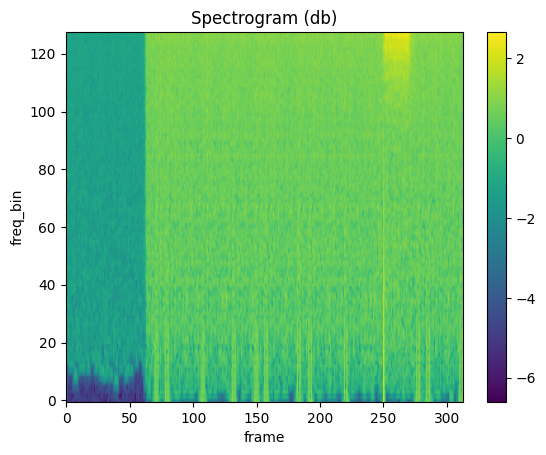

In [5]:
n_fft=1024
win_length=1024
hop_length=512
f_min=20
f_max=15000
n_mels=128

mel_spectrogram = AT.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    f_min=f_min,
    f_max=f_max,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    n_mels=n_mels,
    mel_scale="htk",
    # normalized=True
)

class BirdclefDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode

    def normalize_std(self, spec, eps=1e-23):
        mean = torch.mean(spec)
        std = torch.std(spec)
        return torch.where(std == 0, spec-mean, (spec - mean) / (std+eps))
                
    def __getitem__(self, index):
        sig, _ = torchaudio.load(uri=input_path+self.df.iloc[index].filename,backend="soundfile")
        sig = sig / torch.max(torch.abs(sig))
        sig = sig + 1.5849e-05*(torch.rand(1, min_segment)-0.5) 
        melspec = mel_spectrogram(sig)
        melspec = torch.log(melspec)
        melspec = self.normalize_std(melspec)

        target = self.df.iloc[index].primary_label
        y = np.array([1 if item == target else 0 for item in class_labels])
        
        return melspec, y
    
    def __len__(self):
        return len(self.df)
        
temp_dataset = BirdclefDataset(train_meta, mode='train')
temp_loader = DataLoader(temp_dataset, batch_size=24, shuffle=False, num_workers=1,drop_last=True)
for X, y in temp_loader:
    break
    
plot_spectrogram(X[0,0,:,:])    
del temp_dataset, temp_loader, X, y

### Model

In [6]:
class Model_resnet34(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        model = models.resnet34(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_labels))
        self.model = model

    def forward(self, x):
        x = torch.cat((x,x,x),1)
        x = self.model(x)
        return x

model = Model_resnet34(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


### Train

In [7]:
train_df, val_df = train_test_split(train_meta, test_size=0.2, random_state=42)

train_dataset = BirdclefDataset(train_df, mode='train')
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=2,drop_last=True)

val_dataset = BirdclefDataset(val_df, mode='val')
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=1,drop_last=True)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    pred_train = []
    label_train = []
    running_loss = 0.0
    for melspecs, labels in tqdm(train_loader):
        melspecs, labels = melspecs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(melspecs)
        loss = criterion(outputs, labels.to(torch.float32))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred_train.append(torch.softmax(outputs,dim=1).detach().cpu().numpy())
        label_train.append(labels.detach().cpu().numpy())

    pred_val = []
    label_val = []
    running_loss_val = 0.0
    model.eval()
    with torch.no_grad():
        for melspecs, labels in val_loader:
            melspecs, labels = melspecs.to(device), labels.to(device)
            outputs = model(melspecs)
            loss = criterion(outputs, labels.to(torch.float32))
            running_loss_val += loss.item()
            pred_val.append(torch.softmax(outputs,dim=1).detach().cpu().numpy())
            label_val.append(labels.detach().cpu().numpy())
    
    auc_train_val = cal_score(label_train, pred_train)
    auc_val = cal_score(label_val, pred_val)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Loss_val: {running_loss_val/len(train_loader):.4f}")
    print(f"Auc: {auc_train_val:.2f}% Auc_val: {auc_val:.2f}%")

torch.save(model.state_dict(), "baseline.pth")

100%|██████████| 952/952 [03:55<00:00,  4.05it/s]


Epoch 1/8, Loss: 3.4407, Loss_val: 0.6698
Auc: 0.80% Auc_val: 0.92%


100%|██████████| 952/952 [02:27<00:00,  6.46it/s]


Epoch 2/8, Loss: 2.2756, Loss_val: 0.5309
Auc: 0.93% Auc_val: 0.96%


100%|██████████| 952/952 [02:28<00:00,  6.42it/s]


Epoch 3/8, Loss: 1.7839, Loss_val: 0.4603
Auc: 0.97% Auc_val: 0.96%


100%|██████████| 952/952 [02:29<00:00,  6.36it/s]


Epoch 4/8, Loss: 1.4329, Loss_val: 0.4349
Auc: 0.98% Auc_val: 0.97%


100%|██████████| 952/952 [02:28<00:00,  6.41it/s]


Epoch 5/8, Loss: 1.1487, Loss_val: 0.4215
Auc: 0.99% Auc_val: 0.97%


100%|██████████| 952/952 [02:30<00:00,  6.33it/s]


Epoch 6/8, Loss: 0.8703, Loss_val: 0.4166
Auc: 0.99% Auc_val: 0.97%


100%|██████████| 952/952 [02:29<00:00,  6.36it/s]


Epoch 7/8, Loss: 0.6194, Loss_val: 0.4264
Auc: 1.00% Auc_val: 0.97%


100%|██████████| 952/952 [02:30<00:00,  6.33it/s]


Epoch 8/8, Loss: 0.4214, Loss_val: 0.4612
Auc: 1.00% Auc_val: 0.97%
